### DR5 color distributions using mixture of Gaussians

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
from astropy.table import Table
from astropy.io import fits
from desitarget.targetmask import desi_mask, bgs_mask
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split

import corner as cn

#### Select features to model

In [3]:
def keep(data):
    
    gflux = data['FLUX_G']
    rflux = data['FLUX_R']
    zflux = data['FLUX_Z']
    w1flux = data['FLUX_W1']
    w2flux = data['FLUX_W2']
    
    #only keep non-zero, non-negative flux values to convert to magnitudes
    keep = (gflux > 0) & (rflux > 0) & (zflux > 0) & (w1flux > 0) & (w2flux > 0)

    gg = 22.5-2.5*np.log10(gflux[keep])
    rr = 22.5-2.5*np.log10(rflux[keep])
    zz = 22.5-2.5*np.log10(zflux[keep])
    w1 = 22.5-2.5*np.log10(w1flux[keep])
    w2 = 22.5-2.5*np.log10(w2flux[keep])

    
    return np.array([gg, rr, zz, w1, w2]).T

#### Methods to sample from Gaussian

In [4]:
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def save(model, filename):
        hdus = fits.HDUList()
        hdr = fits.Header()
        hdr['covtype'] = model.covariance_type
        hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
        hdus.append(fits.ImageHDU(model.means_, name='means'))
        hdus.append(fits.ImageHDU(model.covariances_, name='covars'))
        hdus.writeto(filename, overwrite=True)

    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
        
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X
    
def get_bic(data, components_range):
    
    # Generate bic for each component in the range given
        
    bic = []
    for comp in components_range:
        model = GaussianMixture(n_components=comp, covariance_type='full')
        model.fit(data)
        bic.append(model.bic(data))
        #print('Component: {:d}'.format(comp))
    return bic

def plot_bic(bic, components_range, save=None):
    
    # Plot bic for each component
    
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(components_range, np.asarray(np.asarray(bic)/100), marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion/100')
    plt.title('Optimal number of components = {:d}'.format(np.argmin(bic)))
    if save:
        plt.savefig(save)
    plt.show()  


def make_gmm_model(X_data, components_range, model_filename=None, seed=123, bic_plot=False, save=None):
    
    # Create Gaussian Mixture Model based on optimal bic value
    
    # List of bic values for given range of components
    bic = get_bic(X_data, components_range)
    #option to plot bic values
    if bic_plot:
        plot_bic(bic, components_range, save)
    # Index of lowest bic value gives the optimal number of components
    n_comp = np.argmin(bic)
    gen = np.random.RandomState(seed)
    model = GaussianMixture(n_components=n_comp, covariance_type="full", random_state=gen).fit(X_data)
    if model_filename:
        GaussianMixtureModel.save(model, model_filename)
        print('Saved GMM as {:s}.'.format(model_filename))
    else:
        return model
    
def sample(filename, n_targets, random_state):
    
    # Sample from saved Gaussian Mixture Models
    model = GaussianMixtureModel.load(filename)
    return  model.sample(n_targets, random_state)

#### Read target catalog

In [5]:
# Choose the first 5,000,000 rows of dr5 catalog
dr5 = Table.read('dr5_subset.fits')

#### Separate targets by type

In [6]:
lrg = dr5[(dr5['DESI_TARGET'] & desi_mask.LRG).astype(bool)]
elg = dr5[(dr5['DESI_TARGET'] & desi_mask.ELG).astype(bool)]
qso = dr5[(dr5['DESI_TARGET'] & desi_mask.QSO).astype(bool)]
bgs = dr5[(dr5['BGS_TARGET'] & bgs_mask.BGS_BRIGHT).astype(bool)]

In [13]:
# Set up parameters for GMM

N = 10000

seed = 123
gen = np.random.RandomState(seed)

# Number of components to test for bic
components_range = range(1,40)

## LRG

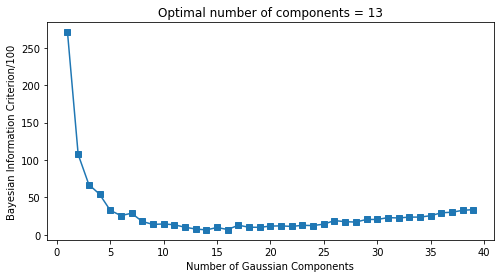

Saved GMM as data/gmm/lrg_gmm.fits.


In [14]:
lrg_data = keep(lrg)
lrg_train, lrg_valid = train_test_split(lrg_data, test_size=0.5, random_state=gen)

# Make GMM model
make_gmm_model(lrg_train[:N], components_range, model_filename='data/gmm/lrg_gmm.fits', 
               bic_plot=True)

# Sample GMM
lrg_GMM = sample('data/gmm/lrg_gmm.fits', n_targets=N, random_state=gen)

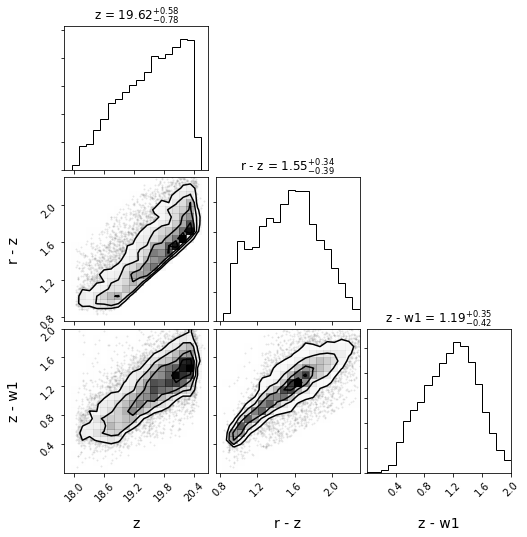

In [15]:
# Training data
z = lrg_train[:N,2]
r_z = lrg_train[:N,1] - lrg_train[:N,2]
z_w1 = lrg_train[:N,2] - lrg_train[:N,3]

fig = cn.corner(np.array([z, r_z, z_w1]).T, labels=["z", "r - z", "z - w1"], range=[(17.8,20.7), (0.75,2.3), (0,2)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

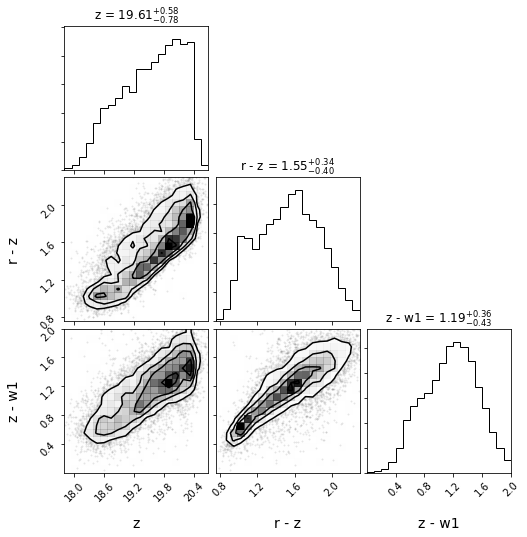

In [16]:
# Sampled from GMM
z = lrg_GMM[:N,2]
r_z = lrg_GMM[:N,1] - lrg_GMM[:N,2]
z_w1 = lrg_GMM[:N,2] - lrg_GMM[:N,3]

fig = cn.corner(np.array([z, r_z, z_w1]).T, labels=["z", "r - z", "z - w1"], range=[(17.8,20.7), (0.75,2.3), (0,2)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

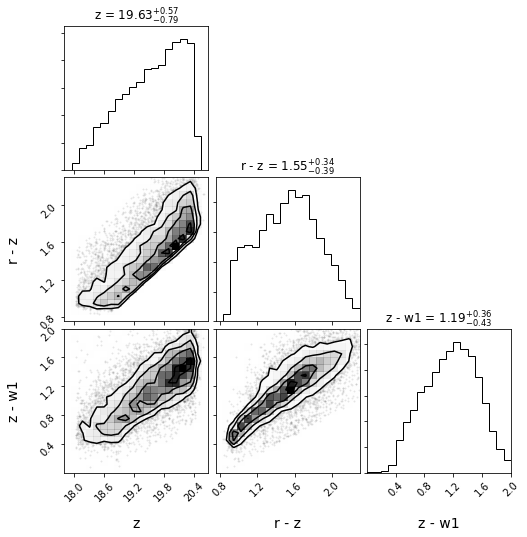

In [17]:
# Validation data
z = lrg_valid[:N,2]
r_z = lrg_valid[:N,1] - lrg_valid[:N,2]
z_w1 = lrg_valid[:N,2] - lrg_valid[:N,3]

fig = cn.corner(np.array([z, r_z, z_w1]).T, labels=["z", "r - z", "z - w1"], range=[(17.8,20.7), (0.75,2.3), (0,2)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

## ELG

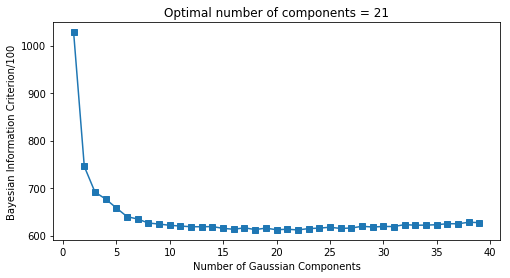

Saved GMM as data/gmm/elg_gmm.fits.


In [18]:
elg_data = keep(elg)
elg_train, elg_valid = train_test_split(elg_data, test_size=0.5, random_state=gen)

# Make GMM model
make_gmm_model(elg_train[:N], components_range, model_filename='data/gmm/elg_gmm.fits', 
               bic_plot=True)

# Sample GMM
elg_GMM = sample('data/gmm/elg_gmm.fits', n_targets=N, random_state=gen)

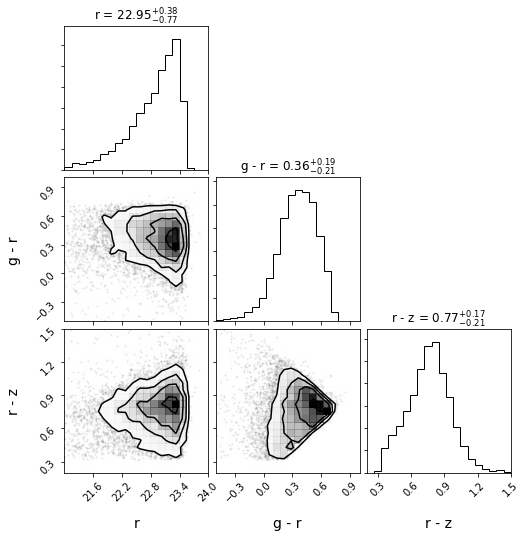

In [19]:
# Training data
r = elg_train[:N,1]
g_r = elg_train[:N,0] - elg_train[:N,1]
r_z = elg_train[:N,1] - elg_train[:N,2]

fig = cn.corner(np.array([r, g_r, r_z]).T, labels=["r", "g - r", "r - z"], range=[(21,24), (-0.5,1.0), (0.2,1.5)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

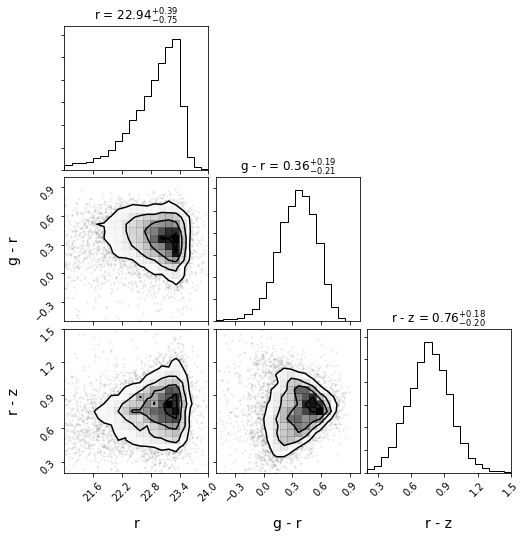

In [20]:
# Sampled from GMM
r = elg_GMM[:N,1]
g_r = elg_GMM[:N,0] - elg_GMM[:N,1]
r_z = elg_GMM[:N,1] - elg_GMM[:N,2]

fig = cn.corner(np.array([r, g_r, r_z]).T, labels=["r", "g - r", "r - z"], range=[(21,24), (-0.5,1.0), (0.2,1.5)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

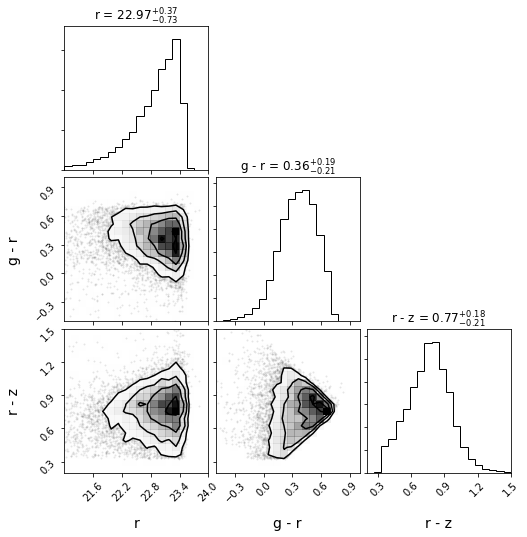

In [21]:
# Validation data
r = elg_valid[:N,1]
g_r = elg_valid[:N,0] - elg_valid[:N,1]
r_z = elg_valid[:N,1] - elg_valid[:N,2]

fig = cn.corner(np.array([r, g_r, r_z]).T, labels=["r", "g - r", "r - z"], range=[(21,24), (-0.5,1.0), (0.2,1.5)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

## QSO

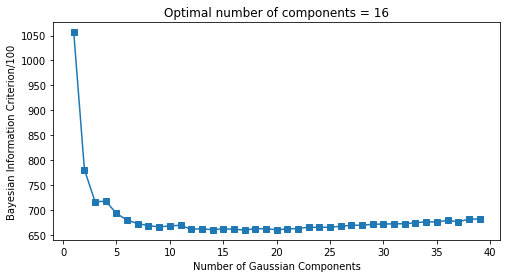

Saved GMM as data/gmm/qso_gmm.fits.


In [22]:
qso_data = keep(qso)
qso_train, qso_valid = train_test_split(qso_data, test_size=0.5, random_state=gen)

# Make GMM model
make_gmm_model(qso_train[:N], components_range, model_filename='data/gmm/qso_gmm.fits', 
               bic_plot=True)

# Sample GMM
qso_GMM = sample('data/gmm/qso_gmm.fits', n_targets=N, random_state=gen)

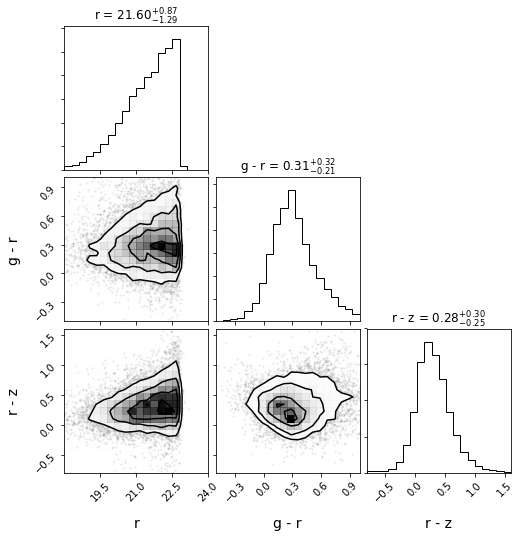

In [23]:
# Training data
r = qso_train[:N,1]
g_r = qso_train[:N,0] - qso_train[:N,1]
r_z = qso_train[:N,1] - qso_train[:N,2]

fig = cn.corner(np.array([r, g_r, r_z]).T, labels=["r", "g - r", "r - z"], 
                range=[(18,24), (-0.5,1), (-0.8,1.6)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

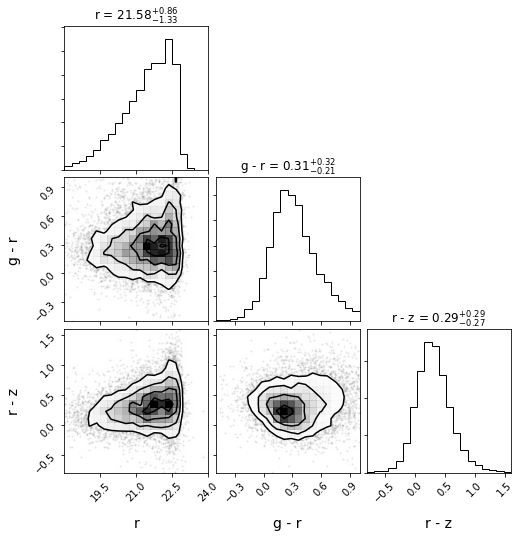

In [24]:
# Sampled from GMM
r = qso_GMM[:N,1]
g_r = qso_GMM[:N,0] - qso_GMM[:N,1]
r_z = qso_GMM[:N,1] - qso_GMM[:N,2]

fig = cn.corner(np.array([r, g_r, r_z]).T, labels=["r", "g - r", "r - z"], 
                range=[(18,24), (-0.5,1), (-0.8,1.6)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

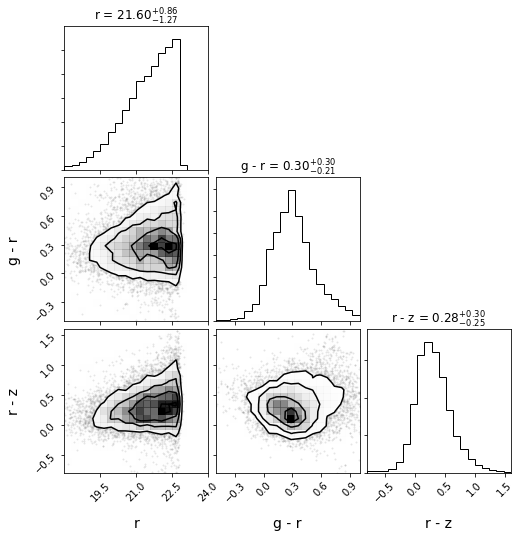

In [25]:
# Validation data
r = qso_valid[:N,1]
g_r = qso_valid[:N,0] - qso_valid[:N,1]
r_z = qso_valid[:N,1] - qso_valid[:N,2]

fig = cn.corner(np.array([r, g_r, r_z]).T, labels=["r", "g - r", "r - z"], 
                range=[(18,24), (-0.5,1), (-0.8,1.6)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

## BGS

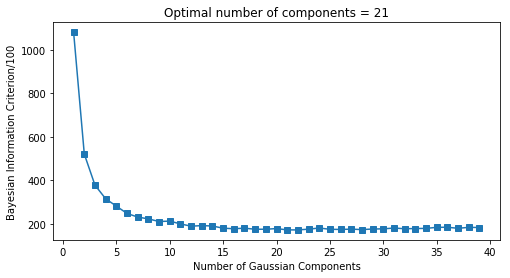

Saved GMM as data/gmm/bgs_gmm.fits.


In [26]:
bgs_data = keep(bgs)
bgs_train, bgs_valid = train_test_split(bgs_data, test_size=0.5, random_state=gen)

# Make GMM model
make_gmm_model(bgs_train[:N], components_range, model_filename='data/gmm/bgs_gmm.fits', 
               bic_plot=True)

# Sample GMM
bgs_GMM = sample('data/gmm/bgs_gmm.fits', n_targets=N, random_state=gen)

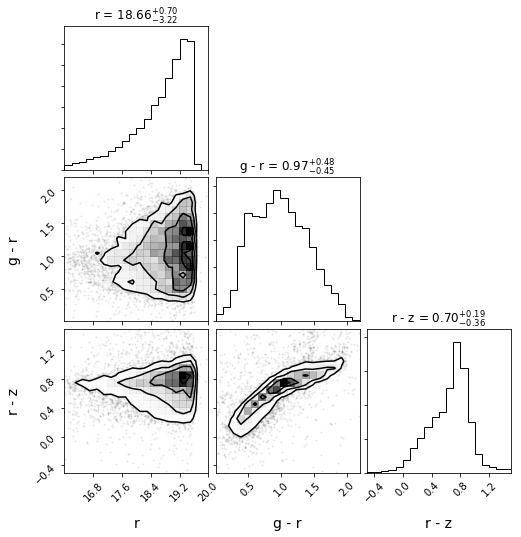

In [27]:
# Training data
r = bgs_train[:N,1]
g_r = bgs_train[:N,0] - bgs_train[:N,1]
r_z = bgs_train[:N,1] - bgs_train[:N,2]

fig = cn.corner(np.array([r, g_r, r_z]).T, labels=["r", "g - r", "r - z"], 
                range=[(16,20), (0,2.2), (-0.5,1.5)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

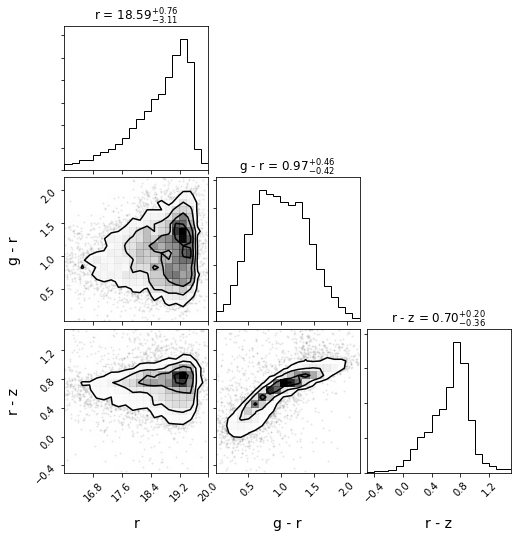

In [28]:
# Sampled from GMM
r = bgs_GMM[:N,1]
g_r = bgs_GMM[:N,0] - bgs_GMM[:N,1]
r_z = bgs_GMM[:N,1] - bgs_GMM[:N,2]

fig = cn.corner(np.array([r, g_r, r_z]).T, labels=["r", "g - r", "r - z"], 
                range=[(16,20), (0,2.2), (-0.5,1.5)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

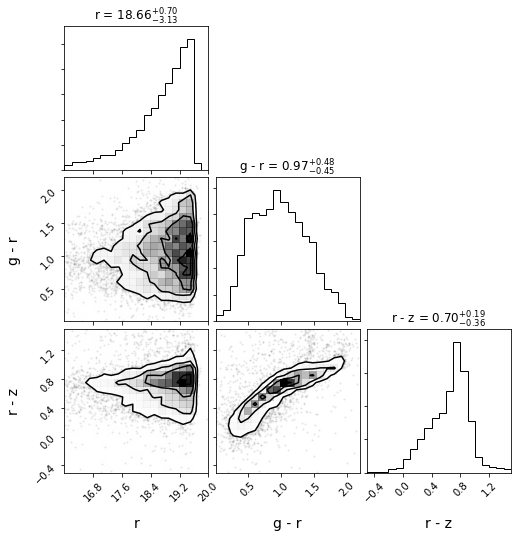

In [29]:
# Validation data
r = bgs_valid[:N,1]
g_r = bgs_valid[:N,0] - bgs_valid[:N,1]
r_z = bgs_valid[:N,1] - bgs_valid[:N,2]

fig = cn.corner(np.array([r, g_r, r_z]).T, labels=["r", "g - r", "r - z"], 
                range=[(16,20), (0,2.2), (-0.5,1.5)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})